# 🧙‍♂️ Sample Generation with Pretrained Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebook.ipynb)

### Initial setup ⚙️

In [1]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Cloning into 'PML_DL_Final_Project'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 307 (delta 19), reused 19 (delta 12), pack-reused 270 (from 1)
Receiving objects: 100% (307/307), 84.27 KiB | 7.66 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [2]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

/content/PML_DL_Final_Project


### 📦 Imports

In [3]:
import torch
import numpy as np

from src.train.train import train
from src.utils.data import get_dataloaders
from src.models.diffusion import Diffusion
from src.utils.plots import plot_image_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

### 🛠️ Configuration Parameters

In [4]:
epochs = 15
batch_size = 256
learning_rate = 1e-3
seed = 1337
checkpoint = None  # e.g., "checkpoints/last.ckpt"
model_name = "unet"
method = "diffusion"  # or "flow"

### 🧪 Setup: Seed and Device

In [5]:
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 🧠 Model Training

#### 📥 Data Loading

In [6]:
train_loader, val_loader = get_dataloaders(batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 352kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]


#### Training

In [7]:
# NOTE: Currently assumes 10 classes are hardcoded
num_classes = 10
model_kwargs = {"num_classes": num_classes}

model = train(
    num_epochs=epochs,
    device=device,
    dataloader=train_loader,
    val_loader=val_loader,
    learning_rate=learning_rate,
    use_wandb=True,
    checkpoint_path=checkpoint,
    model_name=model_name,
    model_kwargs=model_kwargs,
    method=method,
)

WANDB_API_KEY environment variable not set. Please enter your WandB API key: d8dc3ad9caae0ce9504bfcf61be898d8fbdbef18


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/15


Train Loss: 0.0887 | Val Loss: 0.0565 | LR: 0.000989

Epoch 2/15


Train Loss: 0.0540 | Val Loss: 0.0500 | LR: 0.000957

Epoch 3/15


Train Loss: 0.0493 | Val Loss: 0.0493 | LR: 0.000905

Epoch 4/15


Train Loss: 0.0463 | Val Loss: 0.0448 | LR: 0.000836

Epoch 5/15


Train Loss: 0.0450 | Val Loss: 0.0445 | LR: 0.000752

Epoch 6/15


Train Loss: 0.0440 | Val Loss: 0.0426 | LR: 0.000658

Epoch 7/15


Train Loss: 0.0430 | Val Loss: 0.0428 | LR: 0.000557

Epoch 8/15


Train Loss: 0.0428 | Val Loss: 0.0421 | LR: 0.000453

Epoch 9/15


Train Loss: 0.0418 | Val Loss: 0.0416 | LR: 0.000352

Epoch 10/15


Train Loss: 0.0411 | Val Loss: 0.0419 | LR: 0.000258

Epoch 11/15


Train Loss: 0.0409 | Val Loss: 0.0411 | LR: 0.000174

Epoch 12/15


Train Loss: 0.0408 | Val Loss: 0.0394 | LR: 0.000105

Epoch 13/15


Train Loss: 0.0401 | Val Loss: 0.0400 | LR: 0.000053

Epoch 14/15


Train Loss: 0.0400 | Val Loss: 0.0391 | LR: 0.000021

Epoch 15/15


Train Loss: 0.0399 | Val Loss: 0.0394 | LR: 0.000010


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/loss_epoch,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/loss_step,██▄▆▆▅▄▂▂▂▄▃▄▄▅▂▄▄▃▄▄▄▂▃▅▅▄▃▂▄▃▃▁▂▂▃▂▃▁▄
val/loss,█▅▅▃▃▂▃▂▂▂▂▁▁▁▁
best_val_loss,0.0391
epoch,15
train/loss_epoch,0.03991
train/loss_step,0.0327
val/loss,0.03936



Training complete.


## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [8]:
n_samples = 5
save_dir = "samples"
max_steps = 1000
model_name = "unet"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### 🔌 Load Pretrained Model

In [9]:
num_classes = 10  # 🔢 Total number of class labels (e.g., digits 0–9 for MNIST)

model_kwargs = {
    "num_classes": num_classes,
    "time_emb_dim": 128,  # Must match training config
}

model = load_pretrained_model(
    model_name=model_name,
    ckpt_path=ckpt_path,
    device=device,
    model_kwargs=model_kwargs,
)

#### 💨 Initialize Diffusion Process

In [10]:
# 💫 Create diffusion sampler
diffusion = Diffusion(img_size=28, device=device)

# 🕒 Define intermediate steps to visualize progression
num_intermediate = 5
intermediate_steps = np.linspace(max_steps, 0, num_intermediate + 1, dtype=int).tolist()


#### 🖼️ Generate Samples

In [11]:
# 🏷️ Generate label batch: 0, 1, 2, ..., (n_samples - 1) % num_classes
y = torch.arange(n_samples) % num_classes
y = y.to(device)

# 🖌️ Generate samples with intermediate steps logged
all_samples_grouped = diffusion.sample(
    model=model,
    t_sample_times=intermediate_steps,
    log_intermediate=True,
    y=y,  # 👈 Conditional generation
)

print(f"✅ Generated {n_samples} samples with labels: {y.tolist()}")

✅ Generated 5 samples with labels: [0, 1, 2, 3, 4]


#### 🧱 Reshape & Display

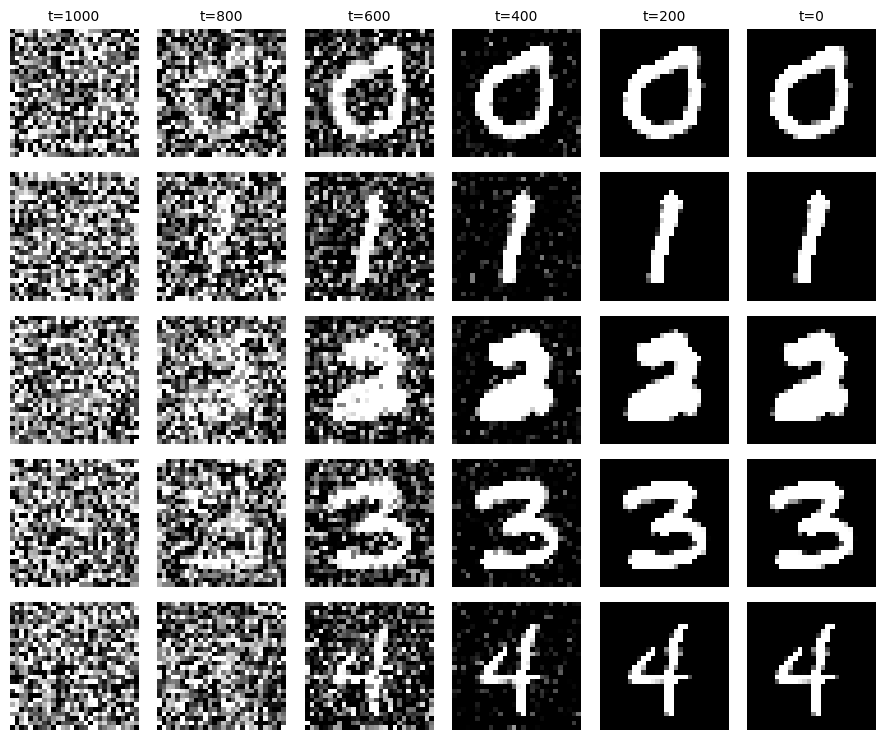

In [12]:
# 📷 Display the generated image grid inline (works in Colab or Jupyter)
from PIL import Image
from IPython.display import display

stacked = torch.stack(all_samples_grouped)         # (T, B, C, H, W)
permuted = stacked.permute(1, 0, 2, 3, 4)           # (B, T, C, H, W)
flat_samples = permuted.reshape(-1, *permuted.shape[2:])  # (B*T, C, H, W)

# 💾 Save generated image grid
os.makedirs(save_dir, exist_ok=True)
out_path = os.path.join(save_dir, "all_samples_grid.png")
plot_image_grid(flat_samples, out_path, num_samples=n_samples, timesteps=intermediate_steps)

display(Image.open(out_path))